In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/afs/cern.ch/work/m/mgarciam/private/PID_GNN/")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


/eos/experiment/fcc/ee/datasets/DC_tracking/Pythia/gun_fakeCalo_g1/reco_gun_1000.root

In [82]:
# This block is the same as 1_dataset.ipynb

#"/eos/experiment/fcc/ee/datasets/DC_tracking/Pythia_evaluation/Zcard/reco_Zcard_1.root"
datasets = {
    "test": "/eos/experiment/fcc/ee/datasets/mlpf/condor/train/single_particles/pion/2/tree.root",
    "train": "/eos/experiment/fcc/ee/datasets/mlpf/condor/train/single_particles/pion/2/tree.root",
}

class Args:
    def __init__(self, datasets):
        self.data_train = [datasets]
        self.data_val = [datasets]
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/PID_GNN/config_files/config_hit_tracks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.2
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 1
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = {key: Args(value) for key, value in datasets.items()}

datas = {}
files_dict = {}
for key in datasets:
    train_range = (0, args[key].train_val_split)
    train_file_dict, train_files = to_filelist(args[key], 'train')
    train_data = SimpleIterDataset(train_file_dict, args[key].data_config, for_training=False,
                                   extra_selection=args[key].extra_selection,
                                   remake_weights=True,
                                   load_range_and_fraction=(train_range, args[key].data_fraction),
                                   file_fraction=args[key].file_fraction,
                                   fetch_by_files=args[key].fetch_by_files,
                                   fetch_step=args[key].fetch_step,
                                   infinity_mode=False,
                                   in_memory=args[key].in_memory,
                                   async_load=False,
                                   name='train')
    datas[key] = train_data
    files_dict[key] = train_files

['/eos/experiment/fcc/ee/datasets/mlpf/condor/train/single_particles/pion/2/tree.root']
['/eos/experiment/fcc/ee/datasets/mlpf/condor/train/single_particles/pion/2/tree.root']


In [83]:
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

In [84]:
itera = iter(train_data)

=== Restarting DataIter train, seed=None ===


In [88]:
# X1 =next(itera) 
g, y = next(itera) 

self.indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
self.cursor 1


In [89]:
g.ndata["label_true"].view(-1,1)
import dgl
hg = dgl.max_nodes(g, 'label_true')
hg

tensor([[0.]])

In [90]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors

mask = (g.ndata['particle_number_nomap'] !=-1) #  +(g.ndata['particle_number_nomap'] ==22)+(g.ndata['particle_number_nomap'] ==23)
tidx =  1*(g.ndata['hit_type'][mask].view(-1,1))
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =  ((g.ndata['e_hits'][mask].view(-1,1))) #g.ndata["e_hits"][mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [14]:
from torch_scatter import scatter_add
scatter_add(torch.ones_like(g.ndata["particle_number"]),g.ndata["particle_number"].long())

tensor([  0., 149.,   8., 468., 251., 150.])

In [11]:
np.log(0.2516)

-1.3799147541558516

In [464]:
mask1 =  (g.ndata['particle_number_nomap'] ==10) # +(g.ndata['particle_number_nomap'] ==184) +(g.ndata['particle_number_nomap'] ==id_particle)+(g.ndata['particle_number_nomap'] ==183)+(g.ndata['particle_number_nomap'] ==185)) * (g.ndata['hit_type'] ==0)
mask2 = (g.ndata['particle_number_nomap'] ==248)
X1 =g.ndata["pos_hits_xyz"][mask1] #[mask]
X2 =g.ndata["pos_hits_xyz"][mask2] #[mask]

In [ ]:
mask1 =  (g.ndata['particle_number_nomap'] ==10) # +(g.ndata['particle_number_nomap'] ==184) +(g.ndata['particle_number_nomap'] ==id_particle)+(g.ndata['particle_number_nomap'] ==183)+(g.ndata['particle_number_nomap'] ==185)) * (g.ndata['hit_type'] ==0)
mask2 = (g.ndata['particle_number_nomap'] ==248)
X1 =g.ndata["pos_hits_xyz"][mask1] #[mask]
X2 =g.ndata["pos_hits_xyz"][mask2] #[mask]

In [438]:
print(torch.abs(torch.min(X1,dim=0)[0]-torch.max(X1,dim=0)[0]))
print(torch.abs(torch.min(X2,dim=0)[0]-torch.max(X2,dim=0)[0]))


tensor([641.3082, 395.7244, 125.4850])
tensor([ 442.7361,  443.6519, 1849.0197])


In [490]:
y[:,5][9]

tensor(0.5759)

In [485]:
# data = X.numpy()
# # Calculate the mean of the points, i.e. the 'center' of the cloud
# datamean = data.mean(axis=0)
# # Do an SD on the mean-centered data.
# uu, dd, vv = np.linalg.svd(data)
X = X /3000
xtx = torch.matmul(torch.transpose(X,0, 1),X)
L, V = torch.linalg.eig(xtx)

In [486]:
vv = V[0]

In [487]:
I_j = torch.eye(3) - torch.Tensor(vv).view(-1,1)*torch.Tensor(vv).view(1,-1)

In [488]:
torch.trace(xtx - I_j*xtx)

tensor(1.3904+0.j)

(6.7939, 11.11, 229)

In [136]:


# Now vv[0] contains the first principal component, i.e. the direction
# vector of the 'best fit' line in the least squares sense.

# Now generate some points along this best fit line, for plotting.

# I use -7, 7 since the spread of the data is roughly 14
# and we want it to have mean 0 (like the points we did
# the svd on). Also, it's a straight line, so we only need 2 points.
# linepts = vv[0] * np.mgrid[-100:100:2j][:, np.newaxis]

# # shift by the mean to get the line in the right place
# linepts += datamean

# # Verify that everything looks right.

# import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d as m3d
# fig = plt.figure(figsize=((10,8)))
# #ax = fig.add_subplot(1, 1, 1, projection = "3d")
# ax = m3d.Axes3D(fig)
# ax.scatter3D(*data.T)
# ax.plot3D(*linepts.T)
# plt.show()



In [44]:
from torch_scatter import scatter_add, scatter_sum, scatter_min, scatter_max
cluster_id = g.ndata["particle_number"]
coord = g.ndata["pos_hits_xyz"]
    # mask_p = y[:, 5] < 0.1

min_x = scatter_min(coord[:, 0], cluster_id.long() - 1)[0]
min_z = scatter_min(coord[:, 2], cluster_id.long() - 1)[0]
max_x = scatter_max(coord[:, 0], cluster_id.long() - 1)[0]
max_z = scatter_max(coord[:, 2], cluster_id.long() - 1)[0]
diff_x = torch.abs(max_x - min_x)
diff_z = torch.abs(max_z - min_z)

In [46]:
diff_x

tensor([1440.8787, 1036.0975, 1041.0920, 1274.8040,  655.5448,  483.0172,
         427.0448,  267.6534,  222.3502,  193.7714])

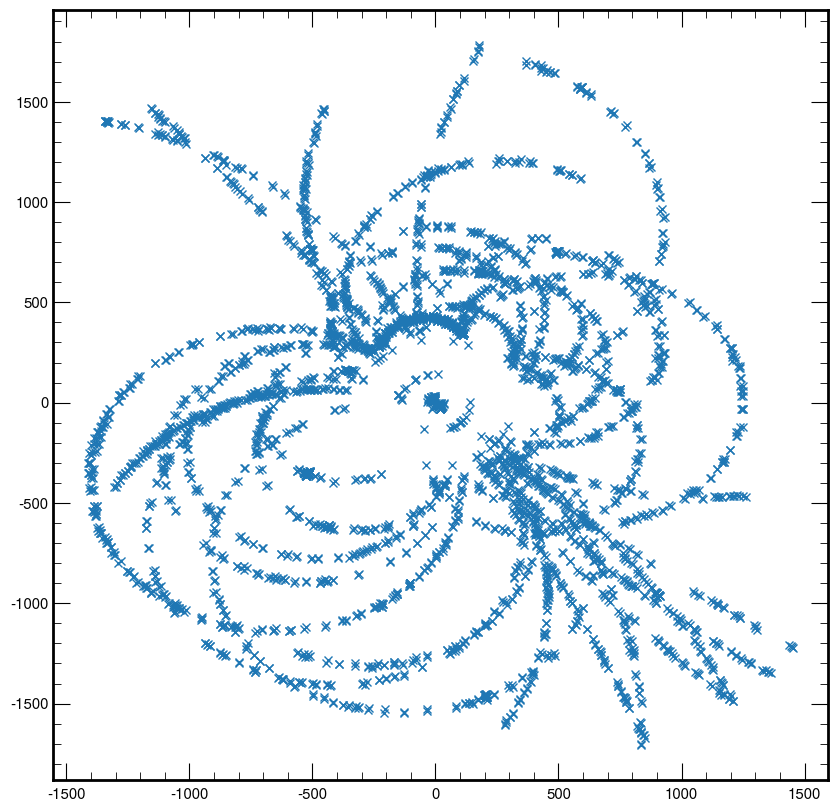

In [40]:
plt.plot(X[:, 0].view(-1, 1).detach().cpu().numpy(),X[:, 1].view(-1, 1).detach().cpu().numpy(), 'x' )

In [38]:
600/(600**2+1200**2)

0.0003333333333333333

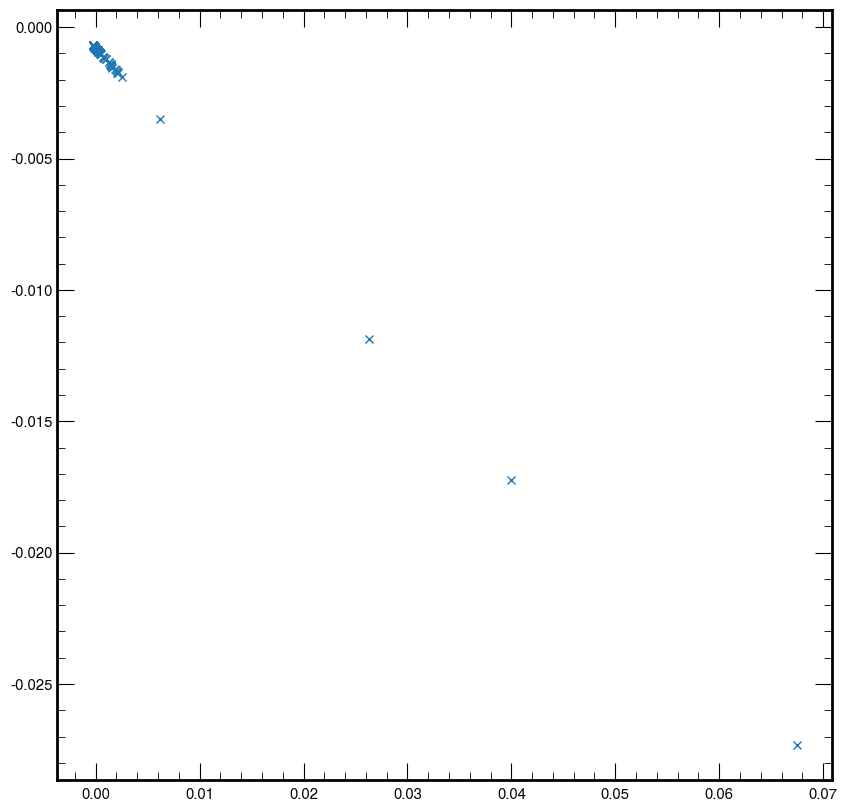

In [36]:
plt.plot(X[:, 0].view(-1, 1).detach().cpu().numpy(),X[:, 1].view(-1, 1).detach().cpu().numpy(), 'x' )

In [35]:
import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors
mask =  (g.ndata['particle_number'] ==2) #+ (g.ndata['particle_number'] ==2)
tidx =  g.ndata['particle_number'][mask].view(-1,1) #[mask].view(-1,1) #(labels_pandora.view(-1,1))
features = torch.ones_like(g.ndata["pos_hits_xyz"][mask][:,0]).view(-1,1)
X =g.ndata["conformal"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [74]:
y[:,5][19]

tensor(6.3174)

In [75]:
print(diff_x)
print(diff_x[17-1])


tensor([ 591.9554, 1524.6696, 1215.1766,  601.7313, 1424.7887,  869.9381,
        1028.0425,   39.3547, 1168.0148,  833.0422,  911.2261,  743.4893,
         553.6189,  762.8918, 1407.3469, 1169.5073, 1517.3787,  170.7072,
         691.4766, 1211.4136,  353.8363, 1425.5258,  945.1639, 1584.8531,
        1193.3240, 1511.7869,  966.7408,  794.0630, 1181.2411,  608.8873,
         332.6471,  795.6431,  768.9578, 1354.5812, 1032.5544,  675.4214])
tensor(1517.3787)


In [65]:
print(diff_z)
print(diff_z[17-1])


tensor([1925.8044,  918.7943, 1492.3574, 1769.1191,  552.5450, 1809.9441,
          84.0756, 1814.7310, 1316.5989,  620.8984,  621.4910,  397.6002,
         807.9369,  867.6551,  600.1616,  517.0481, 1810.5808,  692.5939,
         732.9426,  832.4934,  171.0061,  797.1053, 1352.7126])
tensor(1810.5808)


In [ ]:
1600,1700

In [15]:
# import pandas as pd
# import plotly.express as px
# from src.logger.plotting_tools import shuffle_truth_colors
# tidx =  g.ndata['pandora_pfo'][mask].view(-1,1) #(labels_pandora.view(-1,1))
# features = g.ndata["e_hits"][mask]
# X =g.ndata["pos_hits_xyz"][mask]
# data = {
#             "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
#             "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
#             "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
#             "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
#             "features": features.view(-1, 1).detach().cpu().numpy(),
#         }
# hoverdict = {}
# # if hoverfeat is not None:
# #     for j in range(hoverfeat.shape[1]):
# #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
# #     data.update(hoverdict)

# # if nidx is not None:
# #     data.update({"av_same": av_same})

# df = pd.DataFrame(
# np.concatenate([data[k] for k in data], axis=1),
# columns=[k for k in data],
# )
# rdst = np.random.RandomState(1234567890)  # all the same
# # shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# # if nidx is not None:
# #     hover_data.append("av_same")
# fig = px.scatter_3d(
# df,
# x="X",
# y="Y",
# z="Z",
# color="tIdx",
# size="features",
# hover_data=hover_data,
# template="plotly_dark",
# color_continuous_scale=px.colors.sequential.Rainbow,
# )
# fig.update_traces(marker=dict(line=dict(width=0)))

In [ ]:
labels_pandora = g.ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()

In [10]:
from src.logger.plotting_tools import shuffle_truth_colors
import pandas as pd
import plotly.express as px
tidx = g.ndata["particle_number"]
X = g.ndata["pos_hits_xyz"]
Edep = torch.ones_like(X[:,0]).view(-1,1)
data = {
    "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
    "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
    "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
    "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
    "features": Edep.view(-1, 1).detach().cpu().numpy(),
}
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
# rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size = "features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))
# path= "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/data/coord_n.html"
# fig.write_html(path)

In [ ]:
12,26

In [ ]:
([26, 30, 29,  2,  8, 25, 23, 12, 17, 28, 27, 24, 15,  1, 11,  9, 31, 14,
         6, 10, 
         
         
         
          4, 20,  3, 16,  5, 18,  0, 22, 21,  7, 13, 19]))

In [12]:
from src.logger.plotting_tools import shuffle_truth_colors
import pandas as pd
import plotly.express as px
tidx = g.ndata["particle_number"]
X = g.ndata["h"][:,0:3]
Edep = torch.ones_like(X[:,0]).view(-1,1)*0.5
data = {
    "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
    "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
    "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
    "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
    "features": Edep.view(-1, 1).detach().cpu().numpy(),
}
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
# rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size = "features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [13]:
path= "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/data/coord.html"
fig.write_html(path)

In [128]:
from src.models.gravnet_3_L import GravnetModel
load_model_weights = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/test_L_tracking9/_epoch=30.ckpt" 
model = GravnetModel.load_from_checkpoint(
load_model_weights, args=args, dev=0
)

ModuleNotFoundError: No module named 'torch_cmspepr'